In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml

/fsx/home-rudolf/miniconda3/envs/elk4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda:7"

In [4]:
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
You should 

In [5]:
prompt_config = PromptConfig(dataset_name)
dataset = PromptDataset(prompt_config, split="train")

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 400.51it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


In [6]:
s = set()
for i in range(len(dataset)):
    s.add(dataset[i][0].label)

In [7]:
s

{0, 1}

In [8]:
def dsget(dataset, i):
    dsi = dataset[i][0]
    true, false = list(dsi.to_string(answer_idx) for answer_idx in range(2))
    if dsi.label == 1:
        return (false, true)
    return (true, false)

In [9]:
dsget(dataset, 0)

('What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nWorld politics',
 'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nBusiness')

In [10]:
RPATH = "/fsx/home-rudolf/elk-reporters"

def load_config(name, rpath=RPATH):
    """Loads yaml config from RPATH/[name]/cfg.yaml"""
    with open(os.path.join(rpath, name, "cfg.yaml"), "r") as f:
        return yaml.safe_load(f)

In [11]:
def get_relevant_runs(reqs, rpath=RPATH):
    """Requirements is a dictionary of the form:
    property specification, e.g. "data.prompts.dataset"
    --->
    required value"""
    valid_reporters = []
    for name in os.listdir(rpath):
        cfg = load_config(name, rpath)
        add = True
        for prop, reqval in reqs.items():
            prop_parts = prop.split(".")
            temp = cfg
            for next_level in prop_parts:
                if next_level in temp.keys():
                    temp = temp[next_level]
                else:
                    add = False
                    break
            if temp != reqval:
                add = False
                break
        if add:
            valid_reporters.append(name)
    return valid_reporters

def get_eval(run_name):
    return pd.read_csv(os.path.join(RPATH, run_name, "eval.csv"))

def graph_eval(run_name):
    eval = get_eval(run_name)
    fig, ax = plt.subplots()
    ax.scatter(eval["layer"], eval["acc"], label="acc")
    ax.scatter(eval["layer"], eval["lr_acc"], label="LR acc")
    ax.legend()
    ax.set_title(f"{load_config(run_name)['data']['model']} on {load_config(run_name)['data']['prompts']['dataset']}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    fig.show()

def num_from_str(s):
    """Strip all non-numeric characters from s and interpret as a number"""
    num_str = ''
    for char in s:
        if char.isdigit():
            num_str += char
    if num_str == '':
        return None
    else:
        return int(num_str)

def get_reporters(run_name):
    r_dict = {
        layer_number : t.load(os.path.join(RPATH, run_name, "reporters", layer_name)).to(device)
        for (layer_number, layer_name) in [
            (num_from_str(layer_name), layer_name)
            for layer_name in os.listdir(os.path.join(RPATH, run_name, "reporters"))
            ]
        }
    return [r_dict[i] for i in range(len(r_dict))]

In [12]:
runs = get_relevant_runs(
    {
        "data.prompts.dataset": dataset_name,
        "net.net_name": "eigen",
        "data.model": model_name
    }
)

In [13]:
runs

['infallible-brown', 'priceless-bouman']

In [14]:
run = runs[-1]

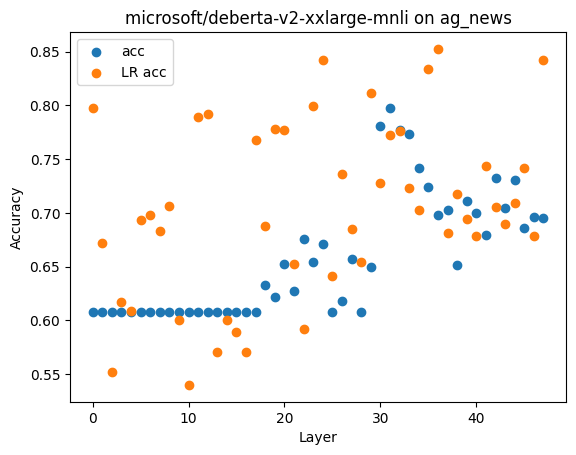

In [15]:
graph_eval(run)

In [16]:
# reporters = get_reporters(run)

In [17]:
# reporters[0]

In [18]:
tokens = tokenizer("This is a test", return_tensors="pt").input_ids.to(device)

In [19]:
outo = model(tokens, output_hidden_states=True)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [20]:
len(outo[1])

49

In [21]:
get_eval(run)

,layer,pseudo_auroc,train_loss,acc,cal_acc,auroc,ece,lr_auroc,lr_acc
0,0,0.5,-2.0085,0.6080,0.5776,0.5479,0.3901,0.8758,0.7976
1,1,0.5,-0.0035,0.6080,0.5621,0.5409,0.3906,0.7443,0.6720
2,2,0.5,-0.0001,0.6080,0.5408,0.5774,0.5862,0.5747,0.5517
3,3,0.5,-0.0004,0.6080,0.5216,0.5595,0.5857,0.6627,0.6175
4,4,0.5,-0.0001,0.6080,0.5211,0.5631,0.5749,0.6351,0.6083
5,5,0.5,-0.0009,0.6080,0.5088,0.5506,0.5858,0.7618,0.6933
6,6,0.5,-0.0005,0.6080,0.5243,0.5737,0.5746,0.7600,0.6976
7,7,0.5,-0.0002,0.6080,0.5685,0.5381,0.3912,0.7353,0.6833
8,8,0.5,-0.0016,0.6080,0.5205,0.5699,0.5740,0.7739,0.7068
9,9,0.5,-0.0001,0.6080,0.5243,0.5655,0.5859,0.6306,0.6008


In [22]:
def reporter_outputs(reporters, sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    out_w_states = model(inputs["input_ids"], output_hidden_states=True)
    # the +1 in i+1 is because the first hidden state is the input embedding
    return t.stack(
        [
            reporter(out_w_states[1][i+1])[0]
            for i, reporter in enumerate(reporters)
        ],
        dim=0
    )

def reporter_output(reporter, sentence):
    return reporter_outputs([reporter], sentence)[0]

def plot_2d_tensor_as_heatmap(t2d):
    fig, ax = plt.subplots()
    heatmap = ax.imshow(t2d.cpu().detach().numpy(), cmap="hot", interpolation="nearest")
    ax.set_xlabel("Token")
    ax.set_ylabel("Reporter (=layer)")
    plt.colorbar(heatmap)

def best_reporter(run_name):
    layer_eval = get_eval(run_name)
    # find the row in the pandas dataframe layer_eval with the highest accuracy:
    best_layer = layer_eval["layer"][layer_eval["acc"].idxmax()]
    reporter = get_reporters(run_name)[best_layer]
    return reporter

def best_layer_output(run_name, sentence):
    reporter = best_reporter(run_name)
    return reporter_outputs([reporter], sentence)[0]

In [23]:
best_layer_output(run, "Is 1+1=2? Yes")

tensor([  56.1649,  324.6794,   33.7451,   32.6317,   95.2264, -145.0999,
         -32.0354,  233.5305,  -53.6458], device='cuda:7',
       grad_fn=<SelectBackward0>)

In [24]:
best_layer_output(run, "Is 1+1=2? No")

: 

: 

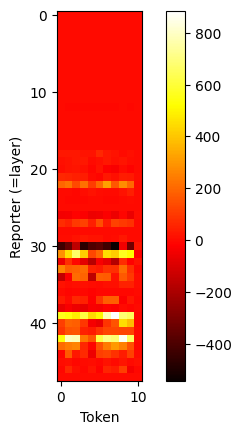

: 

In [ ]:
# plot_2d_tensor_as_heatmap(reporter_outputs(reporters, "Is 1 + 1 = 2? No"))

## Sanity test for reporter

In [61]:
from elk.evaluation.evaluate import (
    evaluate_reporter,
    EvaluateConfig,
    evaluate_reporters
)

In [34]:
eval_config = EvaluateConfig(
    ExtractionConfig(prompt_config, model_name, (45,)),
    run
)

In [63]:
eval_config.target

ExtractionConfig(prompts=PromptConfig(dataset='ag_news', balance=False, data_dir=None, label_column=None, num_classes=None, max_examples=[750, 250], num_shots=0, num_variants=-1, seed=42), model='microsoft/deberta-v2-xxlarge-mnli', layers=(45,), token_loc='last')

In [64]:
ds = extract(eval_config.target, max_gpus=-1)

Using 'train' for training and 'test' for validation
Using all 8 GPUs.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 



100%|██████████| 2/2 [00:00<00:00, 343.80it/s]
Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 404.37it/s]

100%|██████████| 2/2 [00:00<00:00, 343.13it/s]

100%|██████████| 2/2 [00:00<00:00, 414.89it/s]

100%|██████████| 2/2 [00:00<00:00, 431.18it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



100%|██████████| 2/2 [00:00<00:00, 416.56it/s]


	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




100%|██████████| 2/2 [00:00<00:00, 418.16it/s]


Using all prompts per example: ['burns_1', 'burns_2', 'burns_3', 'burns_4', 'burns_5', 'burns_6', 'burns_7', 'burns_8', 'classify', 'classify_question_first', 'classify_with_choices', 'classify_with_choices_question_first', 'recommend', 'which_section', 'which_section_choices']


In [35]:
evaluate_reporters(
    eval_config,
    dataset,
    45,
    devices=[0]
)

AttributeError: 'PromptDataset' object has no attribute 'formatted_as'

In [57]:
def contrast_pair_activations(reporter, dataset, num_examples=10):    
    true_activations = []
    false_activations = []
    for i in range(num_examples):
        (true, false) = dsget(dataset, i)
        true_activations.append(reporter_output(reporter, true).cpu().detach().numpy())
        false_activations.append(reporter_output(reporter, false).cpu().detach().numpy())
    return (true_activations, false_activations)

def ccs_pair_stats(reporter, dataset, num_examples=10):
    true_acts, false_acts = contrast_pair_activations(reporter, dataset, num_examples)
    true_avgs = sum([np.mean(x) for x in true_acts]) / len(true_acts)
    false_avgs = sum([np.mean(x) for x in false_acts]) / len(false_acts)
    true_i_avgs = []
    false_i_avgs = []
    avg_diffs = []
    for i in range(5):
        true_tokens = np.array([x[-i] for x in true_acts])
        false_tokens = np.array([x[-i] for x in false_acts])
        true_i_avgs.append(true_tokens.sum() / true_tokens.shape[0])
        false_i_avgs.append(false_tokens.sum() / false_tokens.shape[0])
        avg_diffs.append((true_tokens - false_tokens).mean())
    return {
        "all": {
            "true_avg": true_avgs,
            "false_avg": false_avgs
        },
        "last_tokens" : {
            i : {
                "true_avg": true_i_avgs[i],
                "false_avg": false_i_avgs[i],
                "avg_diff": avg_diffs[i]
            } for i in range(len(true_i_avgs))
        }
    }

def plot_ccs_pairs(reporter, dataset, num_examples=10):
    true_activations, false_activations = contrast_pair_activations(reporter, dataset, num_examples)
    fig, ax = plt.subplots()
    for x in true_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="green", alpha=0.2)
    for x in false_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="red", alpha=0.2)
    fig.show()

In [58]:
ccs_pair_stats(best_reporter(run), dataset, num_examples=100)

{'all': {'true_avg': -0.5490504348278046, 'false_avg': -0.5463682505488395},
 'last_tokens': {0: {'true_avg': -0.5256773376464844,
   'false_avg': -0.5256265258789062,
   'avg_diff': -5.0874056e-05},
  1: {'true_avg': -0.34209156036376953,
   'false_avg': -0.3422386169433594,
   'avg_diff': 0.0001470481},
  2: {'true_avg': -0.40240631103515623,
   'false_avg': -0.39462043762207033,
   'avg_diff': -0.0077857687},
  3: {'true_avg': -0.3819146728515625,
   'false_avg': -0.37313873291015626,
   'avg_diff': -0.008775895},
  4: {'true_avg': -0.5089014434814453,
   'false_avg': -0.4691994857788086,
   'avg_diff': -0.03970192}}}

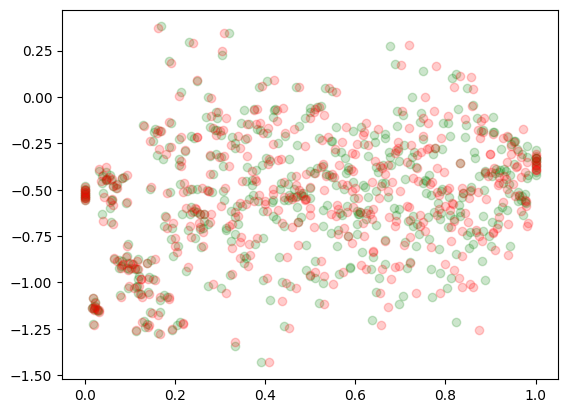

In [38]:
plot_ccs_pairs(best_reporter(run), dataset)